In [1]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import scout

import DeconV as dv

In [2]:
datadir = os.path.join("..", "data", "pbmc")

In [3]:
# Single-cell reference PBMC_3k: http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
adata = sc.read_10x_mtx(
    os.path.join(datadir, "raw/hg19/"),
    var_names="gene_symbols",
)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var = adata.var.reset_index().set_index("gene_ids").rename(columns={"index": "symbol"})
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'symbol', 'n_cells'

In [4]:
# Bulk proportions extracted from Table S6: https://doi.org/10.1016/j.celrep.2019.01.041
proportions = pd.read_table(os.path.join(datadir, "subtype_proportions.txt"), index_col=0)
mapping = {
    'Progenitors':None,
    'B Naive':"B cells",
    'B NSM':"B cells",
    'B SM':"B cells",
    'B Ex':"B cells",
    'Plasmablasts':"B cells",
    'T CD4 Naive':"CD4 T",
    'Tregs':"CD4 T",
    'Tfh':"CD4 T",
    'Th1':"CD4 T",
    'Th1/Th17':"CD4 T",
    'Th17':"CD4 T",
    'Th2':"CD4 T",
    'T CD4 TE':"CD4 T",
    'T CD8 Naive':"CD8 T",
    'T CD8 CM':"CD8 T",
    'T CD8 EM':"CD8 T",
    'T CD8 TE':"CD8 T",
    'T gd Vd2':None,
    'T gd non-Vd2':None,
    'MAIT':None,
    'NK':"NK",
    'pDCs':"DCs",
    'mDCs':"DCs",
    'Monocytes C':"Monocytes",
    'Monocytes I':"Monocytes",
    'Monocytes NC':"Monocytes",
    'Neutrophils LD':None,
    'Basophils LD':None,
}

props = dict([(k,[]) for k in mapping.values() if k is not None])
props["sample"] = []
for row in proportions.iterrows():
    temp = dict()
    props["sample"].append(row[0])
    for k,v in mapping.items():

        if v is not None:
            if v not in temp.keys():
                temp[v] = 0

            temp[v] += row[1][k]

    for k,v in temp.items():
        props[k].append(v)
    
proportions = pd.DataFrame(props).set_index("sample")
proportions = proportions.div(proportions.sum(1), axis=0)
proportions.index += "_PBMC"
proportions.to_csv(os.path.join(datadir, "true.csv"))
proportions

,B cells,CD4 T,CD8 T,NK,DCs,Monocytes
sample,,,,,,
453W_PBMC,0.058854,0.287304,0.320502,0.076899,0.010775,0.245667
684C_PBMC,0.114487,0.341211,0.177874,0.097033,0.014584,0.254811
CR3L_PBMC,0.137329,0.330611,0.186336,0.133018,0.016135,0.196571
FLWA_PBMC,0.102362,0.289034,0.102056,0.238477,0.012963,0.255109
FY2H_PBMC,0.087813,0.239368,0.215721,0.032445,0.016971,0.407682
CYFZ_PBMC,0.098471,0.204259,0.327271,0.164706,0.007765,0.197529
925L_PBMC,0.187059,0.231691,0.223318,0.115577,0.007860,0.234494
9JD4_PBMC,0.094967,0.343631,0.269980,0.086157,0.010984,0.194281
G4YW_PBMC,0.087500,0.284971,0.156894,0.204167,0.009567,0.256901


In [5]:
# Bulk from S13 cohort: GSE107011_Processed_data_TPM.txt.gz
bulk = pd.read_table(os.path.join(datadir, "raw/GSE107011_Processed_data_TPM.txt.gz"), index_col=0)
bulk = bulk[proportions.index]
bulk.index = bulk.index.str.split(".").str[0]
bulk.drop_duplicates(keep=False, inplace=True)

In [6]:
adata = dv.tl.combine(adata, bulk)
adata.var.set_index("symbol", inplace=True)

scRNA-seq data - cells: 2700, genes: 13404
bulk RNA-seq data - samples: 12, genes: 13404


In [7]:
pd.DataFrame(adata.varm["bulk"], columns=adata.uns["bulk_samples"], index=adata.var_names).to_csv(os.path.join(datadir, "bulk.txt"), sep="\t")

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :].copy()
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
adata

AnnData object with n_obs × n_vars = 2634 × 13404
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'bulk_samples'
    varm: 'bulk', 'pseudo', 'pseudo_factor'

In [9]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
adata.layers["ncounts"] = adata.X.copy()
sc.pp.log1p(adata)
adata.layers["centered"] = np.asarray(
    adata.layers["counts"] - adata.layers["counts"].mean(axis=0)
)
adata.layers["logcentered"] = np.asarray(adata.X - adata.X.mean(axis=0))

In [10]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [11]:
sc.tl.pca(adata, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata, n_neighbors=10, random_state=0)
sc.tl.leiden(adata, resolution=0.8, random_state=0)

In [12]:
sc.tl.umap(adata, min_dist=0.5, spread=3.0, random_state=0)

/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


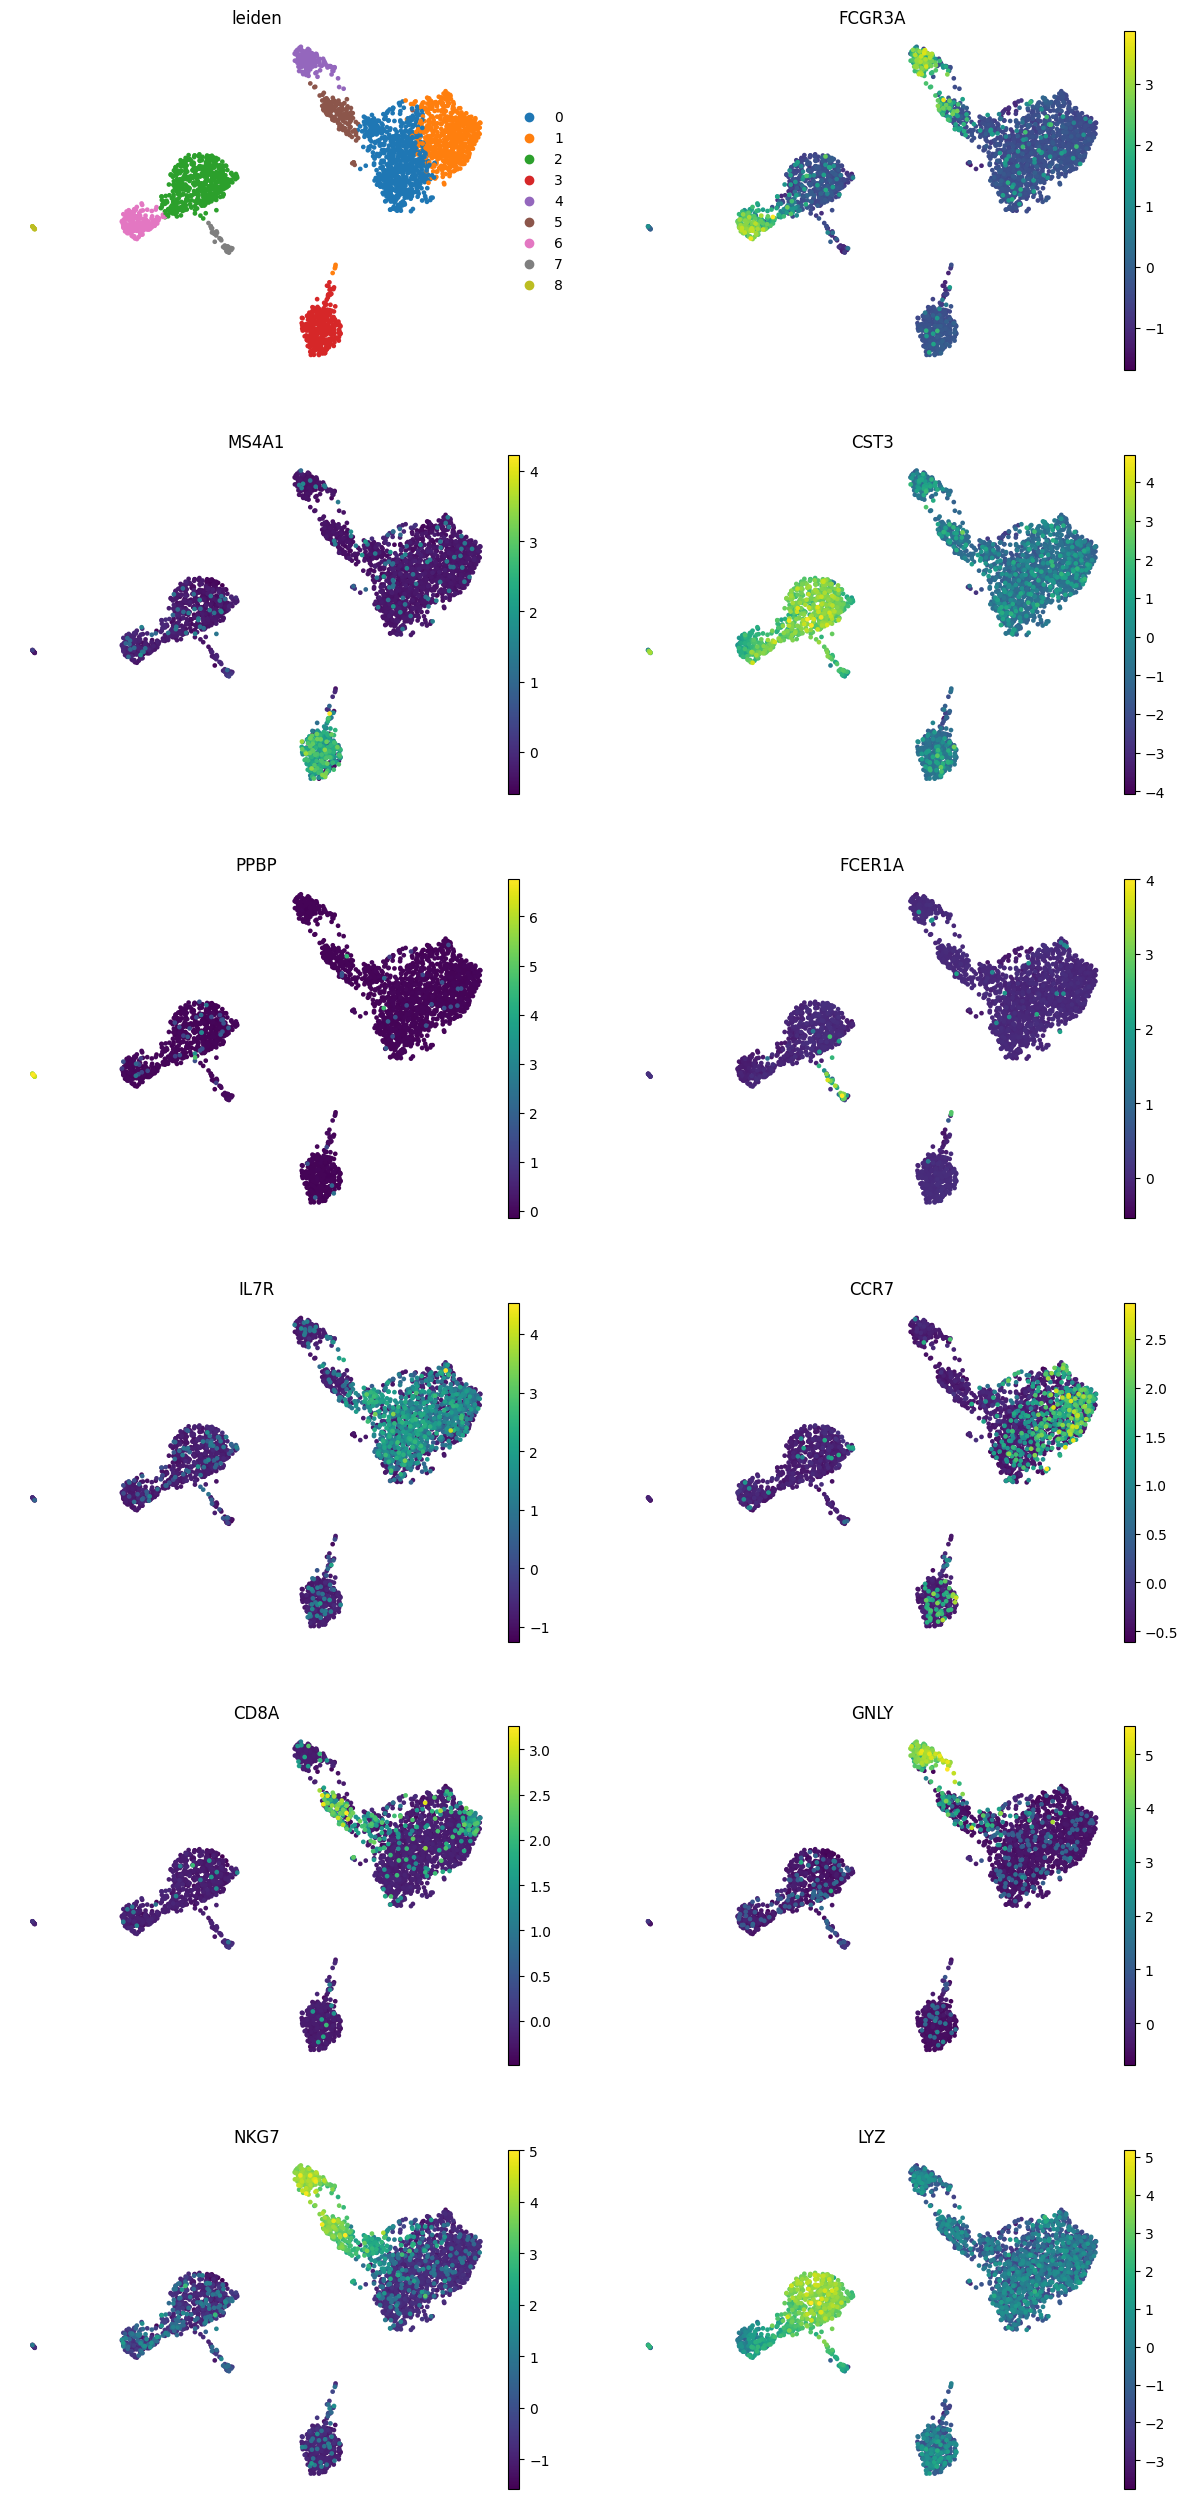

In [13]:
sc.pl.umap(adata, color=['leiden', 'FCGR3A', 'MS4A1', 'CST3', 'PPBP', 'FCER1A', 'IL7R', 'CCR7', 'CD8A', 'GNLY', 'NKG7', 'LYZ'], ncols=2, frameon=False)

In [14]:
adata.obs["labels"] = adata.obs["leiden"].map({"0":"CD4 T", "1":"CD4 T", "2":"Monocytes", "3":"B cells", "4":"NK", "5":"CD8 T", "6":"Monocytes", "7":"DCs", "8":"platelet"}).astype("category")

In [15]:
adata = adata[adata.obs["labels"] != "platelet", :].copy()

In [16]:
adata.obs.groupby("labels").size()

labels
B cells       343
CD4 T        1304
CD8 T         152
DCs            35
Monocytes     635
NK            153
dtype: int64

/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


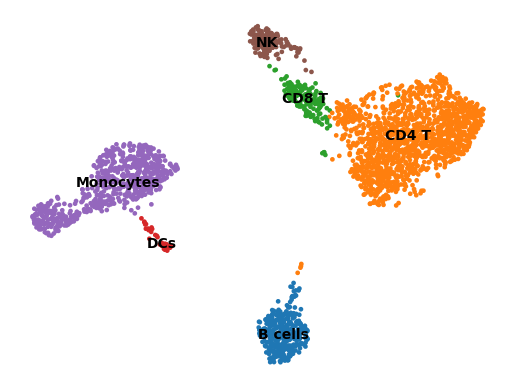

In [17]:
sc.pl.umap(adata, color='labels', legend_loc='on data', title='', frameon=False)

In [18]:
adata.X = adata.layers["counts"]
adata.var.drop(columns=['n_cells', 'mt', 'n_cells_by_counts', 'mean_counts',
       'pct_dropout_by_counts', 'total_counts'], inplace=True)
adata.obs.drop(columns=['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt'], inplace=True)
del adata.layers
del adata.uns
del adata.obsm
del adata.varm
del adata.obsp

In [19]:
adata.write_h5ad(os.path.join(datadir, "reference.h5ad"))